In [ ]:
import pandas as pd
import numpy as np
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("ex.csv")
df.head()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
df = df.rename(columns={
    'Song-Name': 'SongName',
    'Singer/Artists': 'Artists',
    'Album/Movie': 'Movie',
    'User-Rating': 'Rating'

})
df.dropna(inplace=True)
df = df.drop_duplicates()
df.head()

,SongName,Artists,Genre,Movie,Rating
0,Aankh Marey,"Kumar Sanu, Mika Singh, Neha Kakkar",BollywoodDance,Simmba,8.8/10
1,Coca Cola,"Neha Kakkar, Tony Kakkar",BollywoodDanceRomantic,Luka Chuppi,9.0/10
2,Apna Time Aayega,Ranveer Singh,BollywoodDance,Gully Boy,9.7/10
3,Mungda,"Jyotica Tangri, Shaan, Subhro Ganguly",BollywoodDance,Total Dhamaal,9.1/10
4,Tere Bin,"Asees Kaur, Rahat Fateh Ali Khan, Tanishk Bagchi",BollywoodRomantic,Simmba,9.2/10


In [ ]:
def split_genre(text):
    return re.sub(r'([a-z])([A-Z])', r'\1, \2', text)

df['Rating'] = df['Rating'].apply(lambda x: float(str(x).split('/')[0]))

df['Genre'] = df['Genre'].apply(split_genre)
df['Artists'] = df['Artists'].apply(lambda x: x.replace(" ", "").replace(",", ", "))
df['Genre'] = df['Genre'].apply(lambda x: ', '.join(x.split(', ')[1:]) if ', ' in x else '')

df.head()
# print(df.dtypes)

,SongName,Artists,Genre,Movie,Rating
0,Aankh Marey,"KumarSanu, MikaSingh, NehaKakkar",Dance,Simmba,8.8
1,Coca Cola,"NehaKakkar, TonyKakkar","Dance, Romantic",Luka Chuppi,9.0
2,Apna Time Aayega,RanveerSingh,Dance,Gully Boy,9.7
3,Mungda,"JyoticaTangri, Shaan, SubhroGanguly",Dance,Total Dhamaal,9.1
4,Tere Bin,"AseesKaur, RahatFatehAliKhan, TanishkBagchi",Romantic,Simmba,9.2


In [ ]:
df['metadata'] = (df['Genre'] + ' ' + df['Artists'] + ' ' + df['Movie']).str.lower()

df.head()

,SongName,Artists,Genre,Movie,Rating,metadata
0,Aankh Marey,"KumarSanu, MikaSingh, NehaKakkar",Dance,Simmba,8.8,"dance kumarsanu, mikasingh, nehakakkar simmba"
1,Coca Cola,"NehaKakkar, TonyKakkar","Dance, Romantic",Luka Chuppi,9.0,"dance, romantic nehakakkar, tonykakkar luka ch..."
2,Apna Time Aayega,RanveerSingh,Dance,Gully Boy,9.7,dance ranveersingh gully boy
3,Mungda,"JyoticaTangri, Shaan, SubhroGanguly",Dance,Total Dhamaal,9.1,"dance jyoticatangri, shaan, subhroganguly tota..."
4,Tere Bin,"AseesKaur, RahatFatehAliKhan, TanishkBagchi",Romantic,Simmba,9.2,"romantic aseeskaur, rahatfatehalikhan, tanishk..."


In [ ]:
# TF-IDF + Rating
tfidf = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['metadata'])

# Add numeric rating feature
numeric_features = df[['Rating']].values
final_input = np.hstack((tfidf_matrix.toarray(), numeric_features))

# Scale input
scaler = StandardScaler()
final_input_scaled = scaler.fit_transform(final_input)


input_dim = final_input_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Define the models
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Compile
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    final_input_scaled, final_input_scaled,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9988 - val_loss: 1.0486
Epoch 2/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9383 - val_loss: 1.0047
Epoch 3/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8490 - val_loss: 0.9513
Epoch 4/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7568 - val_loss: 0.9012
Epoch 5/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6798 - val_loss: 0.8438
Epoch 6/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6210 - val_loss: 0.8041
Epoch 7/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5715 - val_loss: 0.7686
Epoch 8/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5185 - val_loss: 0.7407
Epoch 9/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4943 - val_loss: 0.7213
Epoch 10/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4647 - val_loss: 0.7008
Epoch 11/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4463 - val_loss: 0.6783
Epoch 12/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4

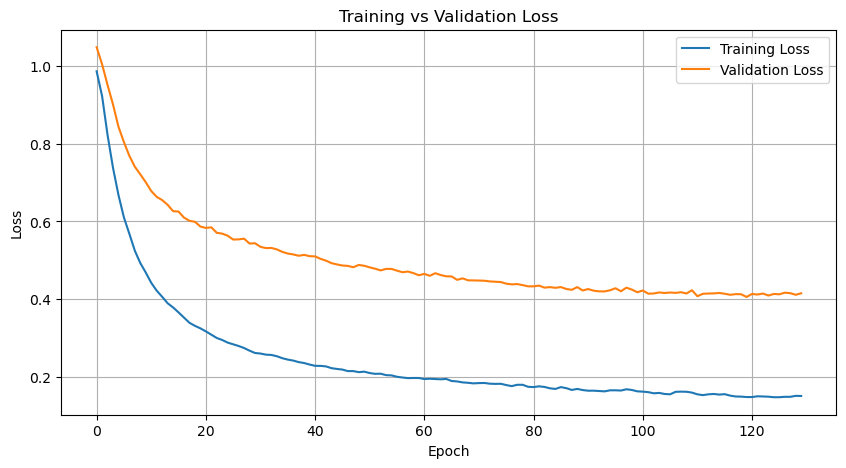

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract compressed features
compressed_vectors = encoder.predict(final_input_scaled)
similarity = cosine_similarity(compressed_vectors)

from flask import jsonify

def recommendation(song_name=None, genre=None, movie=None, artists=None):
    """Recommends similar songs based on song name, genre, movie, or artist."""
    # Convert inputs to lowercase for case-insensitive matching
    song_name = song_name.lower() if song_name else None
    genre = genre.lower() if genre else None
    movie = movie.lower() if movie else None
    artists = artists.lower() if artists else None

    # Create filtering condition
    conditions = []
    if song_name:
        conditions.append(df['SongName'].str.lower() == song_name)
    if genre:
        conditions.append(df['Genre'].fillna('').str.lower() == genre)
    if movie:
        conditions.append(df['Movie'].fillna('').str.lower() == movie)
    if artists:
        conditions.append(df['Artists'].fillna('').str.contains(artists, case=False, na=False))

    # If no conditions provided
    if not conditions:
        return jsonify({"error": "Please provide at least one search criteria!"})

    # Filter dataset based on conditions
    filtered_songs = df[np.logical_or.reduce(conditions)] if conditions else new_music

    # If no matching songs found
    if filtered_songs.empty:
        return jsonify({"message": "No matching songs found!"})

    # Compute similarity scores
    all_distances = []
    for idx in filtered_songs.index:
        if idx >= similarity.shape[0]:  # Ensure index is within bounds
            continue
        all_distances.extend(list(enumerate(similarity[idx])))

    # Sort by similarity score
    all_distances = sorted(all_distances, key=lambda x: x[1], reverse=True)

    # Fetch top 6 unique recommendations
    recommended_songs = []
    seen_songs = set()
    for i in all_distances:
        song = df.iloc[i[0]]['SongName']
        if song not in seen_songs:
            recommended_songs.append(song)
            seen_songs.add(song)
        if len(recommended_songs) == 6:
            break

    return recommended_songs



75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

🎵 Top 5 songs similar to 'Hangover':
 - Jag Ghoomeya (RahatFatehAliKhan) | Similarity: 0.9972
 - Sultan (Mashup) (Multiple) | Similarity: 0.9955
 - Sachi Muchi (HarshdeepKaur, MohitChauhan) | Similarity: 0.9931
 - Bulleya (Papon) | Similarity: 0.9917
 - 440 Volt (MikaSingh) | Similarity: 0.9897


In [ ]:
print(recommendation(song_name="hangover"))
print(recommendation(artists="SalmanKhan"))
print(recommendation(genre="Dance"))

['Jag Ghoomeya (Female)', 'Jag Ghoomeya', 'Sultan (Mashup)', 'Sachi Muchi', 'Bulleya', '440 Volt']
['Jag Ghoomeya (Female)', 'Raah Mein Unse Mulaqat', 'Pyar Ka Anjaam', 'Is Pyar Se Meri Taraf Na Dekho', 'Kisi Se Tum Pyaar Karo', 'Tu Dharti Pe Chaahe Jahan Bhi']
['Dekha Hai Pehli Baar', 'Yaad Hai', 'Tu Itni Khoobsurat Hai', 'Lukka Chuppi', 'Naina Re', 'Tum Tak']


In [ ]:
# Save processed data and model
pickle.dump(df, open('content_music_data.pkl', 'wb'))
pickle.dump(similarity, open('similar_data.pkl', 'wb'))

# Load saved models
df = pickle.load(open('content_music_data.pkl', 'rb'))
similarity = pickle.load(open('similar_data.pkl', 'rb'))